In [151]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pylab import rcParams
from statsmodels.tsa import stattools as st
%matplotlib inline
rcParams['figure.figsize'] = 17,5

In [ ]:
# Pairs trading using data-driven techniques

"""
Pairs trading is the progenitor of statistical arbitrage - statarb - anaylsis.

It's a strategy based on mathematical analysis.
"""

# Underlying principle

"""
If you have two securities and you expect the ratio between their prices to remain relatively constant
because for e.g. they manufacture the same product (Coke and Pepsi)

Sometimes a divergence between these two prices arise, for several possible reasons.

If you expect this divergence to disappear, you can make a pairs trade.

The pairs trade would be to sell the outperforming stock and buy the underperforming stock
"""



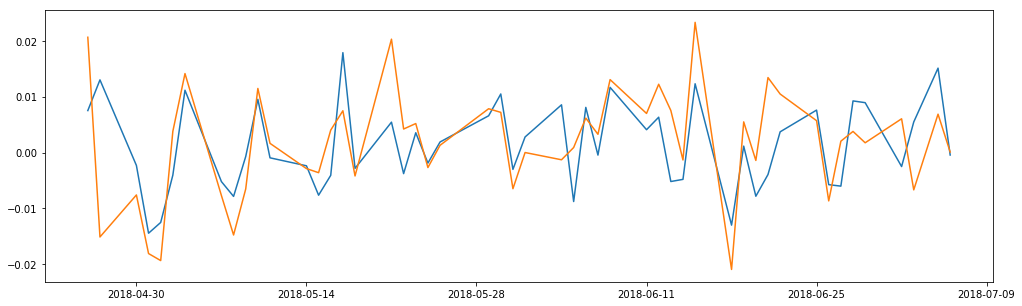

In [307]:
coke = pd.read_csv('ko.csv', index_col= 0)
coke = pd.DataFrame(coke['Adj Close'])
coke.index = pd.to_datetime(coke.index)
coke.columns = ['price']
coke = coke.iloc[-2000:]

pep = pd.read_csv('pep.csv', index_col= 0)
pep = pd.DataFrame(pep['Adj Close'])
pep.index = pd.to_datetime(pep.index)
pep.columns = ['price']
pep = pep.iloc[-2000:]

# Logs

pep_l = pep.apply(lambda x: np.log(x))
coke_l = coke.apply(lambda x: np.log(x))

# Log correlation

pep_l['price'].corr(coke_l['price'])

# Differences

pep_ld = pep_l.diff()
pep_ld.dropna(inplace= True)

coke_ld = coke_l.diff()
coke_ld.dropna(inplace = True)

# Difference Plots

#plt.plot(coke_ld)
#plt.plot(pep_ld)

# Log-diff correlation

#pep_ld['price'].corr(coke_ld['price'])

plt.plot(coke_ld[-50:])
plt.plot(pep_ld[-50:])

In [112]:
# DF test for integration

"""
We'll use the Augmented Dickey Fuller test.

In this test, we test for the null hypothesis that there IS a unit root.

If the test-statistic is smaller (more negative) than the critical statistics, then we REJECT the null hypothesis
of the unit root and find in favour of no unit root.

If the hypothesis is NOT reject, then we find in favour of a unit root presence
"""

# Pepsi

result = st.adfuller(pep_l['price'])

#plt.plot(pep_l)

print 'Augemented Dickey Fuller Test Result %f' % result[0]
print 'p-value %f' % result[1]
print 'Critical values'
for key,value in result[4].items():
    print '\t%s: %.3f' % (key, value)
    
print '\n' +  "There is a %f" % (np.round(result[1]*100,2)) + "% chance of this result, conditional upon a unit root." + '\n'
    
for x in result[4].items():
    if result[0] > x[1]:
        print "Unit Root Present at %s" % str(x[0]) + " significance level."
        

# Coke

result_0 = st.adfuller(coke_l['price'])

print '\n\n\n'

print 'Augemented Dickey Fuller Test Result %f' % result_0[0]
print 'p-value %f' % result_0[1]
print 'Critical values'
for key,value in result_0[4].items():
    print '\t%s: %.3f' % (key, value)
    
print '\n' +  "There is a %f" % (np.round(result_0[1]*100,2)) + "% chance of this result, conditional upon a unit root." + '\n'
    
for x in result_0[4].items():
    if result_0[0] > x[1]:
        print "Unit Root Present at %s" % str(x[0]) + " significance level."


Augemented Dickey Fuller Test Result -0.896440
p-value 0.789142
Critical values
	5%: -2.863
	1%: -3.434
	10%: -2.568

There is a 78.910000% chance of this result, conditional upon a unit root.

Unit Root Present at 5% significance level.
Unit Root Present at 1% significance level.
Unit Root Present at 10% significance level.




Augemented Dickey Fuller Test Result -2.292045
p-value 0.174546
Critical values
	5%: -2.863
	1%: -3.434
	10%: -2.568

There is a 17.450000% chance of this result, conditional upon a unit root.

Unit Root Present at 5% significance level.
Unit Root Present at 1% significance level.
Unit Root Present at 10% significance level.


Cointegration t-statistic: -6.785543
P-value: 0.000000
Critical values array([-3.90743646, -3.34225305, -3.04869817])
Reject at 10% - Cointegration likely


Signals 

Short: 367
Hold: 228
Long: 405


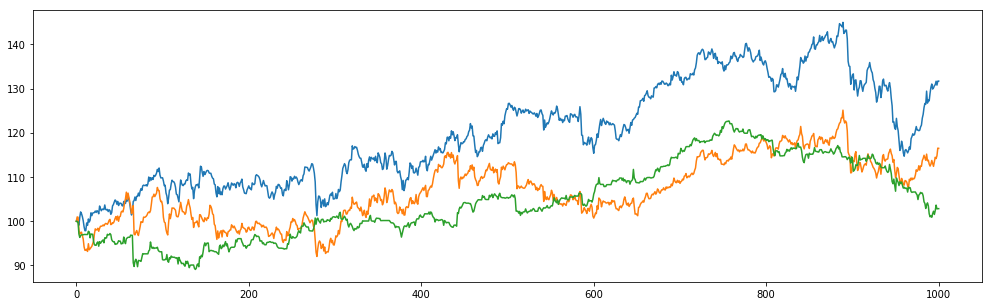

In [339]:
# Cointegration Test

# Null Hypothesis: No cointegration

x = pep_l['price'].diff().dropna()[-1000:]*100
y = coke_l['price'].diff().dropna()[-1000:]*100

x.name = 'X'
y.name = 'Y'

#plt.plot(x)
#plt.plot(y)

#print st.coint(pep_l['price'], coke_l['price'])

def coint(x,y):
    result = statsmodels.tsa.stattools.coint(x,y)
    print "Cointegration t-statistic: %f" % (result[0])
    print "P-value: %f" % (result[1])
    print "Critical values %r" % (result[2])
    if result[0] < result[2][2]:
        print "Reject at 10% - Cointegration likely"
    elif result[0] < result[2][1]:
        print "Reject at 5% - Cointegration probable"
    else:
        print "Reject at 1% - Cointegration very likely"

coint(x,y)


# Diffs

    # By how much does X's return exceed Y's return today?

diffs = x - y


### Signals

    # 1: short X, long Y
    # 0:
    # -1: long X, short Y
    
signals = []

# If X's return exceeds Y's return by more than 0.5% then we have 1 signal
# If X's return falls short of Y's by more than 0.5% then we have a -1 signal

for i in range(len(x)):
    if diffs[i] > 0.15:
        signals.append(1)
    elif diffs[i] < -0.15:
        signals.append(-1)
    else:
        signals.append(0)
    
bench_x = [100]
bench_y = [100]

for i in range(len(x)):
    bench_x.append(bench_x[i]*(1+x[i]/100))
    
for i in range(len(y)):
    bench_y.append(bench_y[i]*(1+y[i]/100))

plt.plot(np.array(bench_x))
plt.plot(np.array(bench_y))

# On a day with a 1 short signal - gain the inverse of X's return, and return of Y
# On a day with a 0 signal - assume you're out
# On a day with a -1 signal - gain the return of X and the inverse of Y

strat = [100]

x

for i in range(len(signals)):
    if signals[i] == 1:
        ret = (x[i+1]/-100 + y[i+1]/100) + 1
        strat.append(strat[i]*(ret))
        #print ret
    elif signals[i] == -1:
        ret = (x[i+1]/100 + y[i+1]/-100) + 1
        strat.append(strat[i]*(ret))
        #print ret
    else:
        strat.append(strat[i])
        #print 0
        
strat = np.array(strat)


print '\n'
print 'Signals \n'
print "Short: " + str(signals.count(-1))
print "Hold: " + str(signals.count(0))
print "Long: " + str(signals.count(1))

plt.plot(strat)

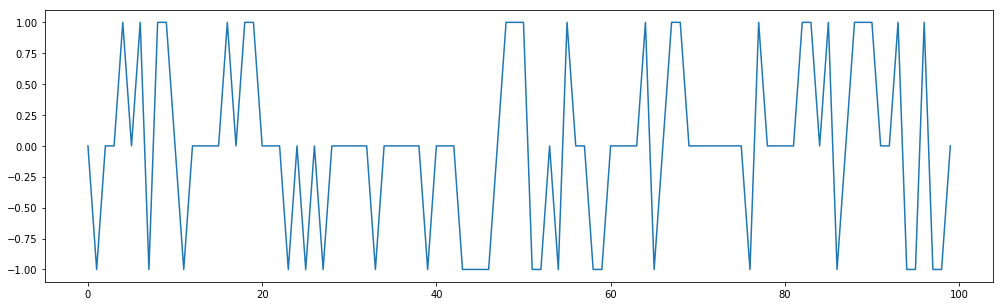

In [299]:

plt.plot(signals)


Date
2018-02-13    0.187446
2018-02-14   -2.739155
2018-02-15    1.690334
2018-02-16    0.081069
2018-02-20   -1.432863
2018-02-21   -1.361070
2018-02-22    1.159913
2018-02-23    0.383665
2018-02-26    1.142254
2018-02-27   -0.045084
2018-02-28   -1.051594
2018-03-01   -0.741775
2018-03-02    0.847304
2018-03-05    0.357027
2018-03-06    0.136983
2018-03-07    0.236981
2018-03-08    2.018817
2018-03-09    0.409584
2018-03-12    0.186424
2018-03-13    0.751053
2018-03-14   -0.875300
2018-03-15   -0.552093
2018-03-16   -0.313016
2018-03-19   -1.153165
2018-03-20   -0.417691
2018-03-21   -1.061116
2018-03-22   -0.738412
2018-03-23   -1.672235
2018-03-26    0.619829
2018-03-27    0.774082
                ...   
2018-05-24   -0.269146
2018-05-25    0.129675
2018-05-29    0.784479
2018-05-30    0.719466
2018-05-31   -0.648268
2018-06-01    0.000000
2018-06-04   -0.129757
2018-06-05    0.089848
2018-06-06    0.616798
2018-06-07    0.326751
2018-06-08    1.306175
2018-06-11    0.700052
2018-0

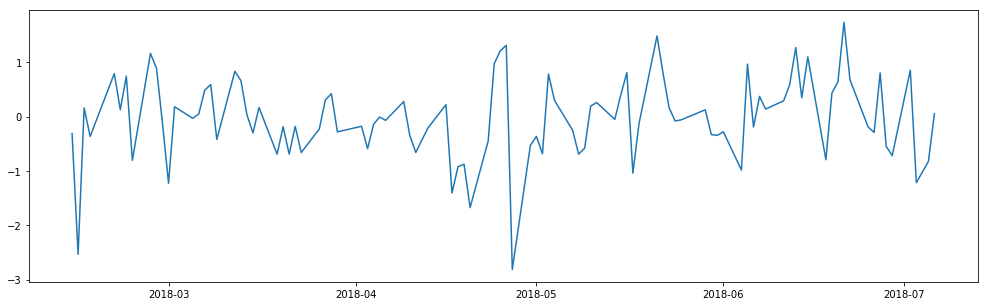

In [325]:
#plt.plot(x)
#plt.plot(y)
plt.plot(diffs)

x

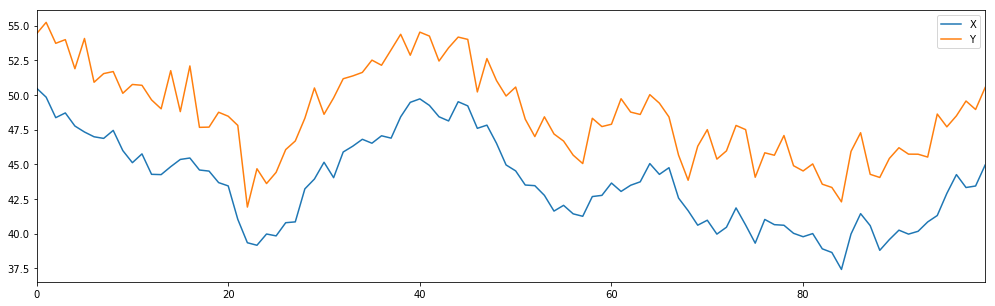

In [170]:
# Quick Fake Detour

np.random.seed(107)

# Gemerate random securities

Xreturns = np.random.normal(0,1,100)

# Sum them to get the value of X each day and shift (to a price around 50?)

X = pd.Series(np.cumsum(Xreturns), name = 'X') + 50

# Generate Y data which is closely related to X

noise = np.random.normal(0,1,100)

Y = X + 5 + noise

Y.name = 'Y'

pd.concat([X, Y], axis = 1).plot()

# Cointegration

## Cointegration means that two series will vary closely around some mean

# Y = aX + e

    # a is a constant ratio
    # e is white noise
    
    

Cointegration t-statistic: -1.684770
P-value: 0.683824
Critical values array([-4.01048603, -3.39854434, -3.08756793])
Reject at 1% - Cointegration very likely


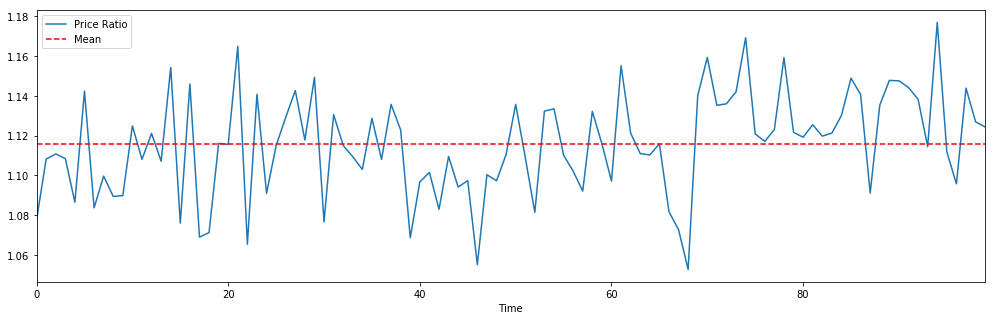

In [188]:
# A continued detour

(Y/X).plot()

plt.axhline((Y/X).mean(), color = 'red', linestyle = '--')

plt.xlabel('Time')
plt.legend(['Price Ratio', 'Mean'])

coint(X,Y)